<pre>
█▄▀ █░░ ▄▀█ █▀ █▄█ █▀▀ █ █▄▀ ▄▀█ ▀█▀ █▀█ █▀█   █▄▄ ▄▀█ ░░█ █▀▀ █▀ █▀█ █░█░█ █▀ █▄▀ █   
█░█ █▄▄ █▀█ ▄█ ░█░ █▀░ █ █░█ █▀█ ░█░ █▄█ █▀▄   █▄█ █▀█ █▄█ ██▄ ▄█ █▄█ ▀▄▀▄▀ ▄█ █░█ █   

▀█▀ █░█ █▀▀   █▀▀ █▀█ █▀▀ ▄▀█ ▀█▀   █▀▄▀█ █▀█ █▀▀   █▀▀ █▀▄ █ ▀█▀ █ █▀█ █▄░█
░█░ █▀█ ██▄   █▄█ █▀▄ ██▄ █▀█ ░█░   █░▀░█ █▄█ █▄█   ██▄ █▄▀ █ ░█░ █ █▄█ █░▀█ 
(AKA I copied it from someone smarter than both me and chatGPT vomit edition)
</pre>

Fajny artykuł na którym oparłem dużą część tego projektu:
Artykuł "Naive Bayes and Hyperparameter Optimization" przedstawia w sposób przystępny podstawy klasyfikatora Naive Bayes oraz techniki optymalizacji hiperparametrów. Obejmuje zarówno teoretyczne aspekty, jak i praktyczne przykłady implementacji w Pythonie, co czyni go wartościowym źródłem wiedzy dla osób zainteresowanych uczeniem maszynowym.

Link do artykułu: [Naive Bayes and Hyperparameter Optimization](https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html)

### Zalety i wady naiwnego klasyfikatora Bajesowskiego w kontekście naszego projektu

**Zalety**

- **Mniejsza złożoność:** Naïve Bayes jest prostszy w porównaniu do innych klasyfikatorów. 
- **Dobra skalowalność:** Jest szybki i efektywny, a także wymaga niewielkiej ilości pamięci.
- **Obsługa danych o wysokiej wymiarowości:** Sprawdza się w przypadkach takich jak klasyfikacja dokumentów, gdzie liczba wymiarów jest wysoka.

**Wady**

- **Zjawisko zerowej częstości:** Występuje, gdy zmienna kategoryczna nie istnieje w zbiorze treningowym, co prowadzi do zerowego prawdopodobieństwa warunkowego. Problem ten można rozwiązać za pomocą wygładzania Laplace’a.
- **Nierealistyczne założenie podstawowe:** Założenie o niezależności warunkowej nie zawsze jest spełnione, co może prowadzić do błędnych klasyfikacji.

**Zastosowania klasyfikatora Naïve Bayes**

- **Filtrowanie spamu:** Jedno z najpopularniejszych zastosowań, gdzie Naïve Bayes służy do klasyfikacji wiadomości jako spam.
- **Klasyfikacja dokumentów:** Używany do klasyfikacji treści, np. artykułów na stronach mediów informacyjnych.
- **Analiza sentymentu:** Pomaga w zrozumieniu opinii i postaw wobec produktów i marek.
- **Przewidywanie stanów umysłowych:** Wykorzystywany w analizie danych fMRI do przewidywania stanów poznawczych ludzi.
źródło IBM


| Nazwa klasyfikatora      | Opis                                                                                       | Założenie                                                     | Nadaje się do                                                    | Przyjęto (wyjaśnienie)    |
|--------------------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------|------------------------------------------------------------------|--------------------------|
| Gaussian Naive Bayes     | Zakłada normalny (gaussowski) rozkład cech w każdej klasie.                                | Cechy mają ciągły rozkład gaussowski.                         | Numeryczne cechy, które są w przybliżeniu normalnie rozłożone.    |✅|
| Multinomial Naive Bayes  | Zaprojektowany dla dyskretnych danych opartych na liczeniu (np. dane tekstowe reprezentowane przez częstotliwość słów). | Cechy są liczbami wystąpień w różnych klasach.                 | Klasyfikacja tekstów, kategoryzacja dokumentów, analiza sentymentu. |❌✅|
| Complement Naive Bayes   | Zakłada cechy binarne lub logiczne, wskazujące obecność lub brak cechy.                     | Cechy są binarne (0/1).                                        | Klasyfikacja tekstów, klasyfikacja danych binarnych.              |❌|
| Categorical Naive Bayes  | Obsługuje cechy kategoryczne, które mogą przyjmować dyskretne wartości bez zakładania żadnego określonego rozkładu. | Cechy są zmiennymi kategorycznymi.                             | Klasyfikacja tekstów, systemy rekomendacyjne z danymi kategorycznymi. |✅|
| Bernoulli Naive Bayes    | Zakłada cechy binarne lub logiczne, wskazujące obecność lub brak cechy.                     | Cechy są binarne (0/1).                                        | Klasyfikacja tekstów, klasyfikacja danych binarnych.              |❌|


In [577]:
# All the Data Science Gang in da hood 
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Scikit-learn libraries
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

#debugging stuff
from typing import Tuple, Optional, Dict, Any
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Data Initialization Documentation
## `initialize_data`
Initializes and preprocesses the data.
### Parameters:
- `scaler_type` (str, optional): The type of scaler to use for preprocessing. 
  - Options are `'minmax'` or `'standard'`. 
  - If `None`, no scaling is applied.
### Returns:
- `Tuple[pd.DataFrame, pd.Series]`: The preprocessed feature data and the target data.

In [578]:
def initialize_data(scaler_type: Optional[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    # Load data from CSV files
    X = pd.read_csv('wineData.csv')
    y = pd.read_csv('wineRatings.csv')
    y = y.values.ravel()
    
    # Log data information
    logging.info(f"X shape: {X.shape}, y shape: {y.shape}")

    # Preprocess data using the specified scaler
    if scaler_type in ["minmax", "standard"]:
        scaler = MinMaxScaler() if scaler_type == "minmax" else StandardScaler()
        X = scaler.fit_transform(X)
        logging.info(f"Data scaled using {scaler_type} scaler.")
    else:
        logging.info("No scaling applied.")

    return X, y


# Common Functions

# Function Documentation

## `evaluate_model`

Evaluates a model using K-Fold Cross Validation.

### Parameters:
- `X_train` (np.ndarray): Training feature data.
- `y_train` (np.ndarray): Training target data.
- `model` (Any): The machine learning model to evaluate.
- `cv_splits` (int): Number of cross-validation splits.
- `random_state` (int): Random state for reproducibility.

### Returns:
- `Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]`: Mean accuracy, last fold test data, last fold test targets, last fold predictions, list of accuracy scores for each fold.

## `optimize_hyperparameters`

Optimizes hyperparameters using RandomizedSearchCV.

### Parameters:
- `X_train` (np.ndarray): Training feature data.
- `y_train` (np.ndarray): Training target data.
- `estimator` (Any): The machine learning model to optimize.
- `param_grid` (Dict[str, Any]): The parameter grid to search.
- `n_iter` (int): Number of parameter settings sampled.
- `cv_splits` (int): Number of cross-validation splits.
- `random_state` (int): Random state for reproducibility.

### Returns:
- `Dict[str, Any]`: Best parameters found by RandomizedSearchCV.

## `optimize_hyperparameters_mb`

Optimizes hyperparameters for MultinomialNB using RandomizedSearchCV.

### Parameters:
- `X_train` (np.ndarray): Training feature data.
- `y_train` (np.ndarray): Training target data.
- `param_grid` (Dict[str, Any]): The parameter grid to search.
- `random_state` (int): Random state for reproducibility.
- `estimator` (Any): The machine learning model to optimize.
- `n_iter` (int): Number of parameter settings sampled.

### Returns:
- `Dict[str, Any]`: Best parameters found by RandomizedSearchCV.

## `cross_validation_with_optimized_hyperparameters`

Performs cross-validation with optimized hyperparameters.

### Parameters:
- `X_train` (np.ndarray): Training feature data.
- `y_train` (np.ndarray): Training target data.
- `model` (Any): The machine learning model to evaluate.
- `best_params` (Dict[str, Any]): Best parameters found by hyperparameter optimization.
- `cv_splits` (int): Number of cross-validation splits.
- `random_state` (int): Random state for reproducibility.
- `model_name` (str): The name of the model ('GaussianNB' or 'MultinomialNB').

### Returns:
- `Dict[str, Any]`: Cross-validation results.


In [579]:
def evaluate_model(X_train: np.ndarray, y_train: np.ndarray, model: Any, cv_splits: int = 10, random_state: int = 2137) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]:
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    accuracy_scores = []

    for train_index, test_index in kfold.split(X_train):
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, y_pred)
        accuracy_scores.append(accuracy)
        logging.info(f"Accuracy for this fold: {accuracy * 100:.2f}%")

    mean_accuracy = np.mean(accuracy_scores)
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

def optimize_hyperparameters(X_train: np.ndarray, y_train: np.ndarray, estimator: Any, param_grid: Dict[str, Any], n_iter: int = 10, cv_splits: int = 5, random_state: int = 42) -> Dict[str, Any]:
    random_search = RandomizedSearchCV(estimator, param_distributions=param_grid, n_iter=n_iter, cv=cv_splits, scoring='accuracy', random_state=random_state)
    random_search.fit(X_train, y_train)
    return random_search.best_params_

def cross_validation_with_optimized_hyperparameters(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any], cv_splits: int = 5, random_state: int = 42, model_name: str = 'GaussianNB') -> Dict[str, Any]:
    if model_name == 'GaussianNB':
        model.var_smoothing = best_params.get('var_smoothing', model.var_smoothing)
        scaler = StandardScaler()
    elif model_name == 'ComplementNB':
        model.alpha = best_params.get('alpha', model.alpha)
        model.force_alpha = best_params.get('force_alpha', model.force_alpha)
        model.fit_prior = best_params.get('fit_prior', model.fit_prior)
        model.norm = best_params.get('norm', model.norm)
        scaler = MinMaxScaler()

    pipe = make_pipeline(SimpleImputer(strategy='mean'), scaler, model)
    kfold = KFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_results = cross_validate(pipe, X_train, y_train, cv=kfold, return_train_score=True)
    return cv_results

## Reports and plots
# Function Documentation

## `generate_report`

Generates a classification report and confusion matrix.

### Parameters:
- `y_test` (Any): Actual target values.
- `y_pred` (Any): Predicted target values.

### Returns:
- `Dict[str, Any]`: The classification report as a dictionary.

## `plot_actual_vs_predicted`

Plots actual vs predicted values.

### Parameters:
- `y_test` (Any): Actual target values.
- `y_pred` (Any): Predicted target values.
- `ax` (plt.Axes): Matplotlib Axes object to plot on.

## `plot_confusion_matrix`

Plots the confusion matrix.

### Parameters:
- `y_test` (Any): Actual target values.
- `y_pred` (Any): Predicted target values.
- `ax` (plt.Axes): Matplotlib Axes object to plot on.

## `plot_classification_report`

Plots metrics from a classification report.

### Parameters:
- `report` (Dict[str, Any]): The classification report as a dictionary.
- `ax` (plt.Axes): Matplotlib Axes object to plot on.


In [580]:
def generate_report(y_test: Any, y_pred: Any) -> Dict[str, Any]:
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    logging.info("Classification report:\n%s", classification_report(y_test, y_pred, zero_division=1))
    logging.info("Confusion matrix:\n%s", confusion_matrix(y_test, y_pred))
    return report

def plot_actual_vs_predicted(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    test_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
    test_df.plot(ax=ax, marker='o')
    ax.legend(['Actual', 'Predicted'])
    ax.set_title('Actual vs Predicted values')
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')

def plot_confusion_matrix(y_test: Any, y_pred: Any, ax: plt.Axes) -> None:
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

def plot_classification_report(report: Dict[str, Any], ax: plt.Axes) -> None:
    report_df = pd.DataFrame(report).transpose()
    report_df.drop(columns='support', inplace=True)
    report_df.plot(kind='bar', ax=ax)
    ax.set_title('Classification Report Metrics')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_ylim(0, 1)
    ax.legend(loc='lower right')

# Gaussian Naive Bayes
# Function Documentation

## `initialize_and_split_data`

Initializes data and splits it into training and testing sets.

### Parameters:
- `scaler_type` (str): The type of scaler to use for preprocessing.

### Returns:
- `Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]`: Split data (X_train, X_test, y_train, y_test).

## `evaluate_initial_model`

Evaluates the initial model using cross-validation.

### Parameters:
- `X` (np.ndarray): Feature data.
- `y` (np.ndarray): Target data.
- `model` (Any): The machine learning model to evaluate.

### Returns:
- `Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]`: Evaluation results.

## `perform_hyperparameter_optimization`

Performs hyperparameter optimization using RandomizedSearchCV.

### Parameters:
- `X_train` (np.ndarray): Training feature data.
- `y_train` (np.ndarray): Training target data.
- `model` (Any): The machine learning model to optimize.

### Returns:
- `Dict[str, Any]`: Best hyperparameters found.

## `cross_validate_with_optimized_params`

Performs cross-validation with optimized hyperparameters.

### Parameters:
- `X_train` (np.ndarray): Training feature data.
- `y_train` (np.ndarray): Training target data.
- `model` (Any): The machine learning model to evaluate.
- `best_params` (Dict[str, Any]): Best hyperparameters found.

### Returns:
- `Dict[str, Any]`: Cross-validation results.

## `display_plots`

Displays various plots including actual vs predicted, confusion matrix, classification report, cross-validation results, and feature importance.

### Parameters:
- `y_fold_test` (np.ndarray): Actual target values for the last fold.
- `y_pred` (np.ndarray): Predicted target values for the last fold.
- `report` (Dict[str, Any]): Classification report for the last fold.
- `cv_results` (Dict[str, Any]): Cross-validation results.
- `accuracy_without_optimization` (float): Accuracy without hyperparameter optimization.
- `accuracy_with_optimization` (float): Accuracy with hyperparameter optimization.
- `model` (Any): The trained model for feature importance plotting.

## `gaussian_naive_bayes_main`

Main function to initialize data, evaluate the model, perform hyperparameter optimization, generate reports, and plot the results.



2024-05-30 01:50:47,071 - INFO - X shape: (1503, 7), y shape: (1503,)
2024-05-30 01:50:47,074 - INFO - Data scaled using standard scaler.
2024-05-30 01:50:47,076 - INFO - Data initialization and splitting complete.
2024-05-30 01:50:47,079 - INFO - Accuracy for this fold: 49.59%
2024-05-30 01:50:47,082 - INFO - Accuracy for this fold: 53.72%
2024-05-30 01:50:47,082 - INFO - Accuracy for this fold: 56.67%
2024-05-30 01:50:47,086 - INFO - Accuracy for this fold: 51.67%
2024-05-30 01:50:47,086 - INFO - Accuracy for this fold: 56.67%
2024-05-30 01:50:47,086 - INFO - Accuracy for this fold: 60.83%
2024-05-30 01:50:47,086 - INFO - Accuracy for this fold: 55.00%
2024-05-30 01:50:47,101 - INFO - Accuracy for this fold: 57.50%
2024-05-30 01:50:47,104 - INFO - Accuracy for this fold: 66.67%
2024-05-30 01:50:47,106 - INFO - Accuracy for this fold: 53.33%
2024-05-30 01:50:47,106 - INFO - Mean accuracy score over all folds: 56.16%
2024-05-30 01:50:47,106 - INFO - Accuracy for the last fold: 53.33%
2

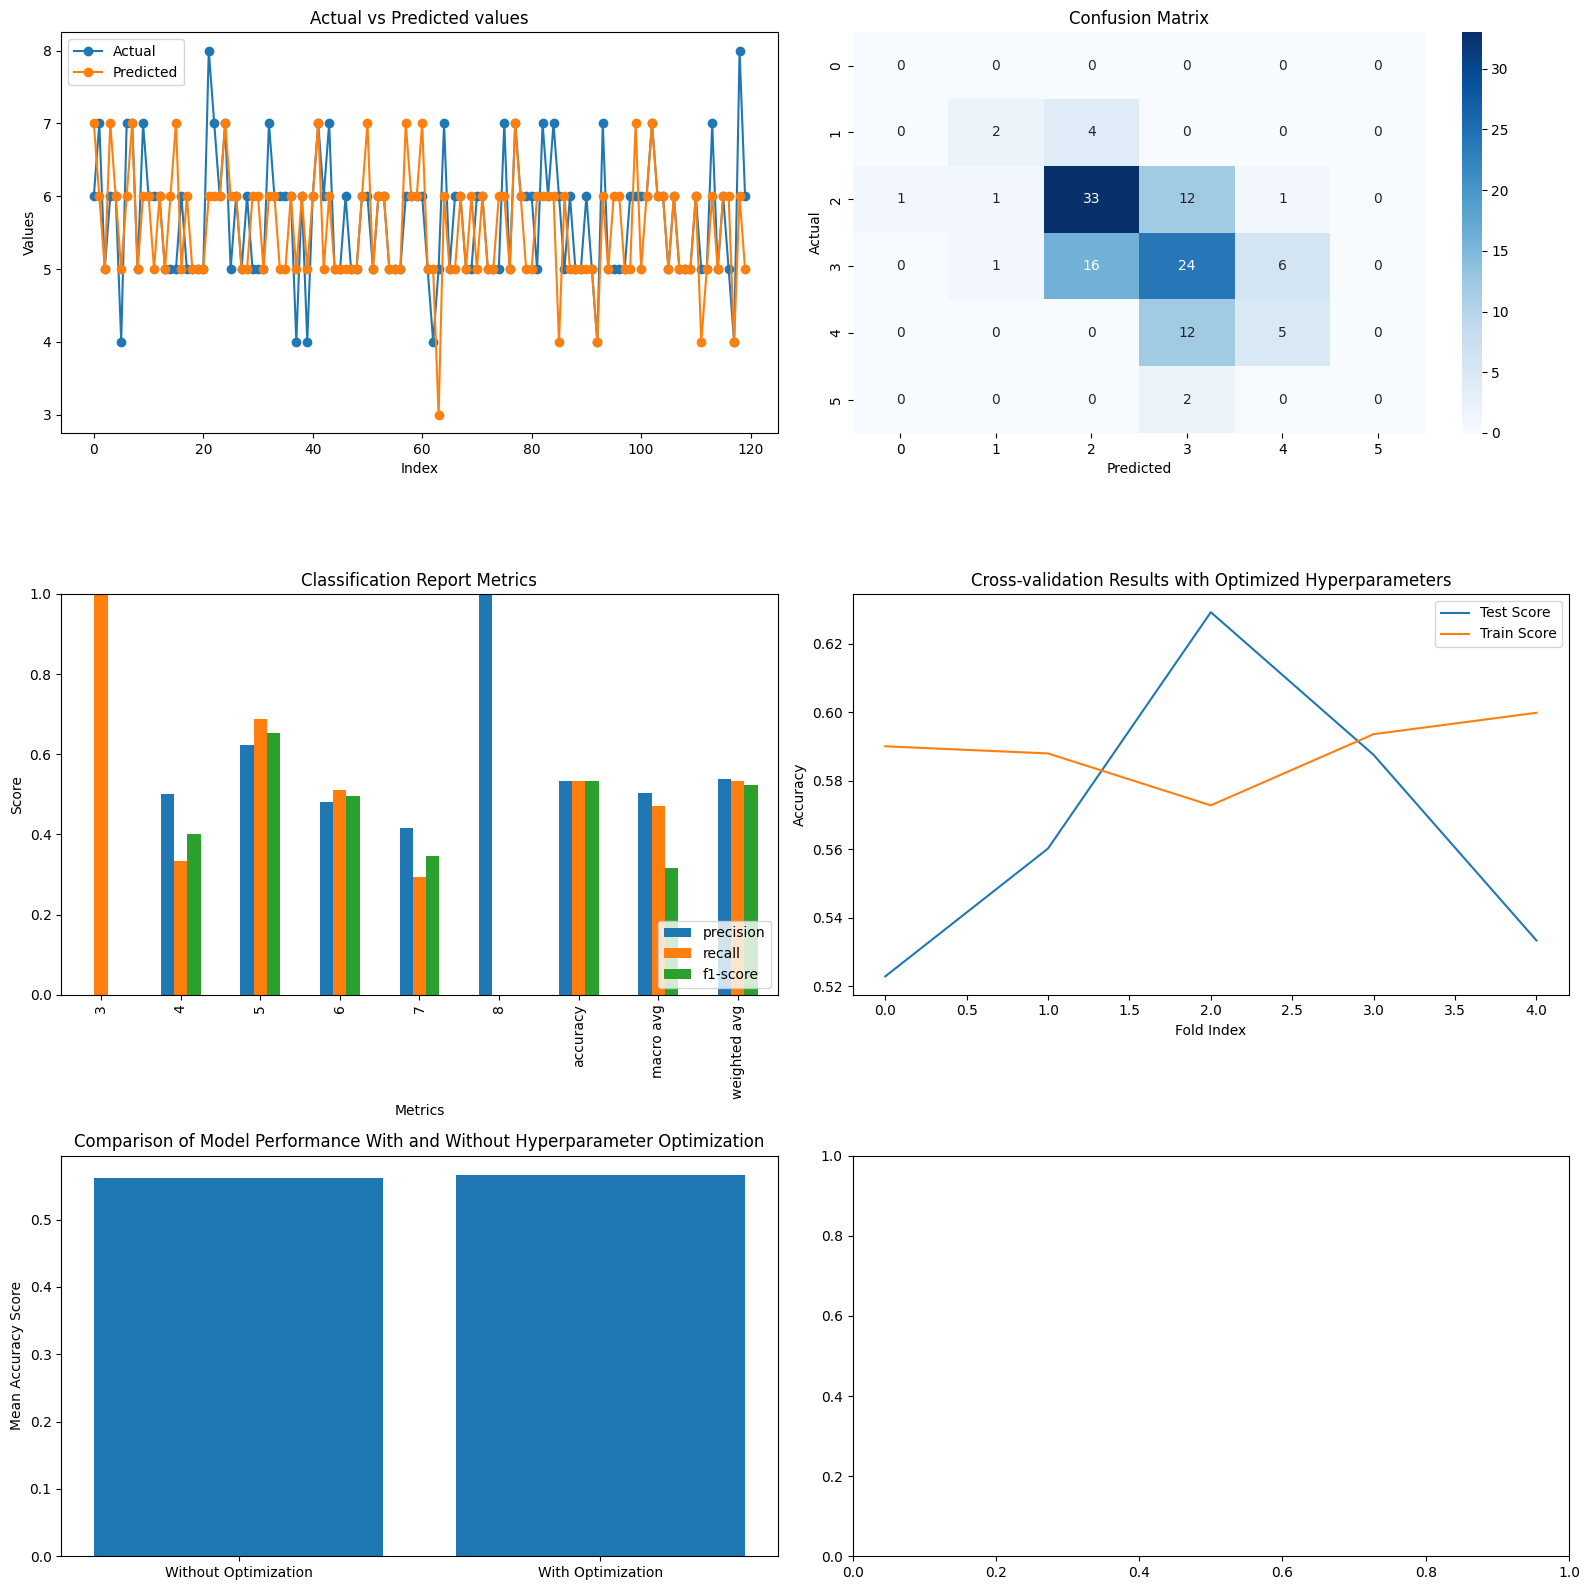

In [581]:
def initialize_and_split_data(scaler_type: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X, y = initialize_data(scaler_type)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def evaluate_initial_model(X: np.ndarray, y: np.ndarray, model: Any) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]:
    mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_model(X, y, model)
    logging.info(f"Mean accuracy score over all folds: {mean_accuracy * 100:.2f}%")
    logging.info(f"Accuracy for the last fold: {accuracy_scores[-1] * 100:.2f}%")
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

def perform_hyperparameter_optimization(X_train: np.ndarray, y_train: np.ndarray, model: Any) -> Dict[str, Any]:
    param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}
    best_strategy = optimize_hyperparameters(X_train, y_train, model, param_grid)
    logging.info(f"Best strategy: {best_strategy}")
    return best_strategy

def cross_validate_with_optimized_params(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any]) -> Dict[str, Any]:
    cv_results = cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, model_name='GaussianNB')
    logging.info(f"Cross-validation results: {cv_results}")
    return cv_results

def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    # Plot actual vs predicted values for the last fold
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    # Plot confusion matrix for the last fold
    plot_confusion_matrix(y_fold_test, y_pred, axs[0, 1])
    # Plot classification report for the last fold
    plot_classification_report(report, axs[1, 0])
    # Plot cross-validation results
    ax_cv = axs[1, 1]
    ax_cv.plot(cv_results['test_score'], label='Test Score')
    ax_cv.plot(cv_results['train_score'], label='Train Score')
    ax_cv.set_xlabel('Fold Index')
    ax_cv.set_ylabel('Accuracy')
    ax_cv.set_title('Cross-validation Results with Optimized Hyperparameters')
    ax_cv.legend()
    # Plot the accuracy scores comparison
    ax_comp = axs[2, 0]
    ax_comp.bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    ax_comp.set_ylabel('Mean Accuracy Score')
    ax_comp.set_title('Comparison of Model Performance With and Without Hyperparameter Optimization')
    # Display the plots
    plt.tight_layout()
    plt.show()

def gaussian_naive_bayes_main():
    try:
        # Initialize and split data
        X_train, X_test, y_train, y_test = initialize_and_split_data("standard")
        logging.info("Data initialization and splitting complete.")

        # Initial Model Evaluation
        gnb = GaussianNB()
        mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_initial_model(X_train, y_train, gnb)
        accuracy_without_optimization = mean_accuracy

        # Report Generation for the Last Fold
        report = generate_report(y_fold_test, y_pred)

        # Hyperparameter Tuning
        best_strategy = perform_hyperparameter_optimization(X_train, y_train, gnb)

        # Cross-validation with the optimized hyperparameters
        cv_results = cross_validate_with_optimized_params(X_train, y_train, gnb, best_strategy)
        accuracy_with_optimization = np.mean(cv_results['test_score'])

        # Display plots
        display_plots(y_fold_test, y_pred, report, cv_results, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    gaussian_naive_bayes_main()

# Complement Naive Bayes

2024-05-30 01:50:48,439 - INFO - X shape: (1503, 7), y shape: (1503,)
2024-05-30 01:50:48,444 - INFO - Data scaled using minmax scaler.
2024-05-30 01:50:48,446 - INFO - Data initialization and splitting complete.
2024-05-30 01:50:48,450 - INFO - Accuracy for this fold: 48.76%
2024-05-30 01:50:48,453 - INFO - Accuracy for this fold: 54.55%
2024-05-30 01:50:48,457 - INFO - Accuracy for this fold: 52.50%
2024-05-30 01:50:48,460 - INFO - Accuracy for this fold: 50.00%
2024-05-30 01:50:48,462 - INFO - Accuracy for this fold: 51.67%
2024-05-30 01:50:48,466 - INFO - Accuracy for this fold: 55.00%
2024-05-30 01:50:48,468 - INFO - Accuracy for this fold: 53.33%
2024-05-30 01:50:48,471 - INFO - Accuracy for this fold: 53.33%
2024-05-30 01:50:48,473 - INFO - Accuracy for this fold: 57.50%
2024-05-30 01:50:48,476 - INFO - Accuracy for this fold: 53.33%


2024-05-30 01:50:48,476 - INFO - Mean accuracy score over all folds: 53.00%
2024-05-30 01:50:48,477 - INFO - Accuracy for the last fold: 53.33%
2024-05-30 01:50:48,490 - INFO - Classification report:
              precision    recall  f1-score   support

           4       1.00      0.00      0.00         6
           5       0.58      0.75      0.65        48
           6       0.47      0.55      0.51        47
           7       0.67      0.12      0.20        17
           8       1.00      0.00      0.00         2

    accuracy                           0.53       120
   macro avg       0.74      0.28      0.27       120
weighted avg       0.58      0.53      0.49       120

2024-05-30 01:50:48,490 - INFO - Confusion matrix:
[[ 0  5  1  0  0]
 [ 0 36 11  1  0]
 [ 0 21 26  0  0]
 [ 0  0 15  2  0]
 [ 0  0  2  0  0]]
2024-05-30 01:50:48,586 - INFO - Best strategy: {'norm': True, 'force_alpha': True, 'fit_prior': True, 'alpha': 6.892612104349702}
2024-05-30 01:50:48,606 - INFO - Cross

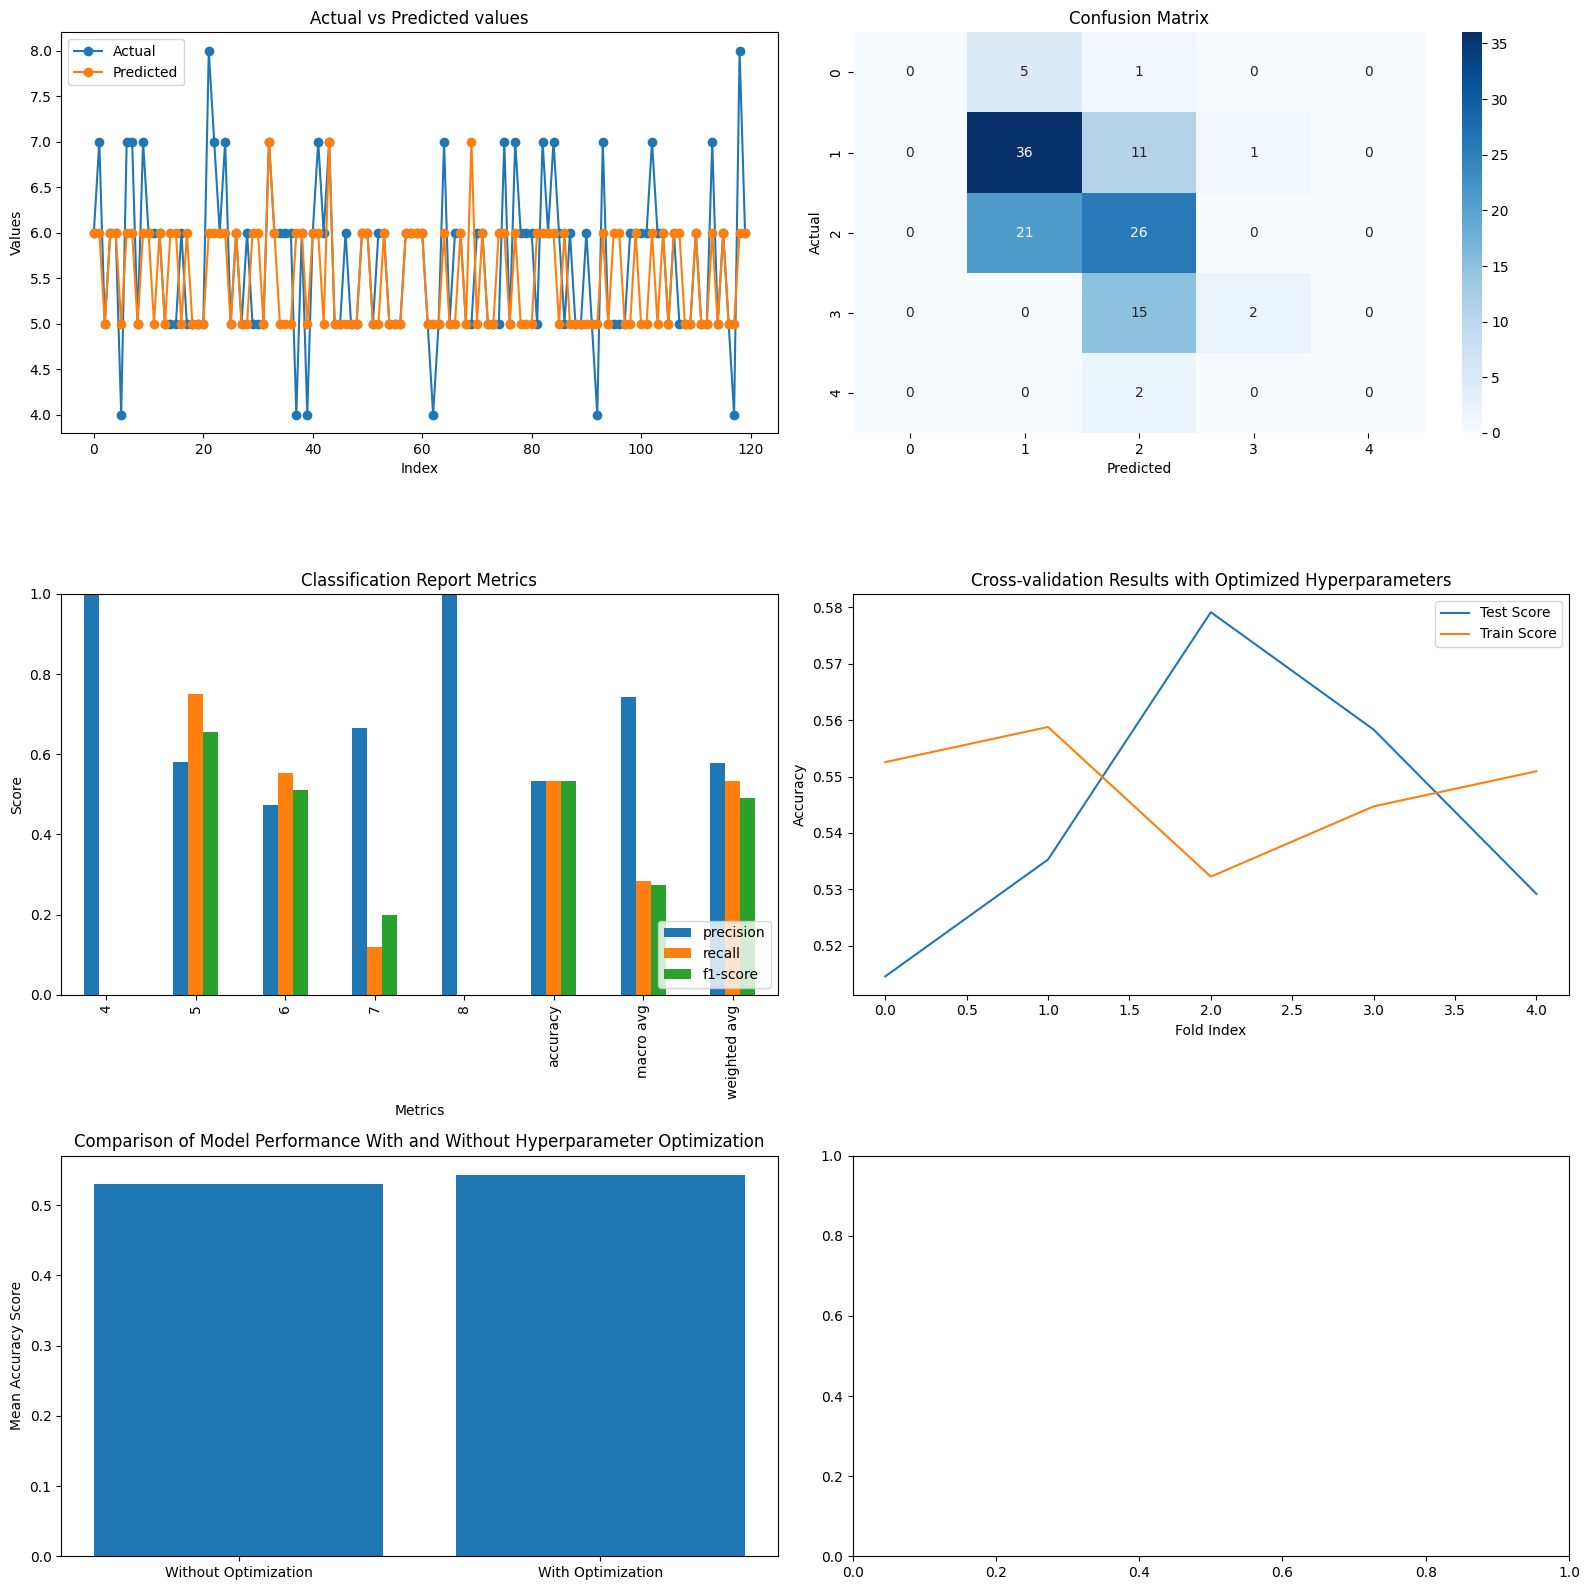

In [582]:
def evaluate_initial_model(X: np.ndarray, y: np.ndarray, model: Any) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, list]:
    mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_model(X, y, model)
    logging.info(f"Mean accuracy score over all folds: {mean_accuracy * 100:.2f}%")
    logging.info(f"Accuracy for the last fold: {accuracy_scores[-1] * 100:.2f}%")
    return mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores

def perform_hyperparameter_optimization(X_train: np.ndarray, y_train: np.ndarray, model: Any) -> Dict[str, Any]:
    param_grid = {
            'alpha': np.logspace(-3, 1, num=100),
            'force_alpha': [True, False],
            'fit_prior': [True, False],
            'norm': [True, False]
        }
    best_strategy = optimize_hyperparameters(X_train, y_train, model, param_grid)
    logging.info(f"Best strategy: {best_strategy}")
    return best_strategy

def cross_validate_with_optimized_params(X_train: np.ndarray, y_train: np.ndarray, model: Any, best_params: Dict[str, Any]) -> Dict[str, Any]:
    cv_results = cross_validation_with_optimized_hyperparameters(X_train, y_train, model, best_params, model_name='ComplementNB')
    logging.info(f"Cross-validation results: {cv_results}")
    return cv_results

def display_plots(y_fold_test: np.ndarray, y_pred: np.ndarray, report: Dict[str, Any], cv_results: Dict[str, Any], accuracy_without_optimization: float, accuracy_with_optimization: float) -> None:
    fig, axs = plt.subplots(3, 2, figsize=(16, 16))
    # Plot actual vs predicted values for the last fold
    plot_actual_vs_predicted(y_fold_test, y_pred, axs[0, 0])
    # Plot confusion matrix for the last fold
    plot_confusion_matrix(y_fold_test, y_pred, axs[0, 1])
    # Plot classification report for the last fold
    plot_classification_report(report, axs[1, 0])
    # Plot cross-validation results
    ax_cv = axs[1, 1]
    ax_cv.plot(cv_results['test_score'], label='Test Score')
    ax_cv.plot(cv_results['train_score'], label='Train Score')
    ax_cv.set_xlabel('Fold Index')
    ax_cv.set_ylabel('Accuracy')
    ax_cv.set_title('Cross-validation Results with Optimized Hyperparameters')
    ax_cv.legend()
    # Plot the accuracy scores comparison
    ax_comp = axs[2, 0]
    ax_comp.bar(['Without Optimization', 'With Optimization'], [accuracy_without_optimization, accuracy_with_optimization])
    ax_comp.set_ylabel('Mean Accuracy Score')
    ax_comp.set_title('Comparison of Model Performance With and Without Hyperparameter Optimization')
    # Display the plots
    plt.tight_layout()
    plt.show()

def complement_naive_bayes_main():
    try:
        # Initialize and split data
        X_train, X_test, y_train, y_test = initialize_and_split_data("minmax")
        logging.info("Data initialization and splitting complete.")

        # Initial Model Evaluation
        cnb = ComplementNB()
        mean_accuracy, X_fold_test, y_fold_test, y_pred, accuracy_scores = evaluate_initial_model(X_train, y_train, cnb)
        accuracy_without_optimization = mean_accuracy

        # Report Generation for the Last Fold
        report = generate_report(y_fold_test, y_pred)

        # Hyperparameter Tuning
        best_strategy = perform_hyperparameter_optimization(X_train, y_train, cnb)

        # Cross-validation with the optimized hyperparameters
        cv_results = cross_validate_with_optimized_params(X_train, y_train, cnb, best_strategy)
        accuracy_with_optimization = np.mean(cv_results['test_score'])

        # Display plots
        display_plots(y_fold_test, y_pred, report, cv_results, accuracy_without_optimization, accuracy_with_optimization)

    except Exception as e:
        logging.error("An error occurred during model evaluation and plotting.", exc_info=True)

if __name__ == "__main__":
    complement_naive_bayes_main()